# Введение

**Анализ тональности текстовых комментариев**

Нам потребуется библиотека datasets от HuggingFace. Она содержит большое число датасетов, которые используются в NLP.

Будем использовать [датасет](https://huggingface.co/datasets/blinoff/kinopoisk) кинопоиска

Так же нам понадобится библиотека [razdel](https://natasha.github.io/razdel/) из проекта [natasha](https://github.com/natasha/natasha) 

И библиотеки для лемматизации 

Мы разберем:
1. Предобработку текста
2. Эмбеддинг
3. Текстовую классификацию

# 0 часть. Загрузка датасета и библиотек 

In [1]:
%%capture
!pip install datasets

In [2]:
%%capture
!pip install -q razdel

In [3]:
%%capture
!pip install -q pymorphy2

In [4]:
%%capture
!pip install mlxtend

In [5]:
# подключим библиотеки
# для предобработки данных 
import re
import string
import unicodedata
import razdel
import nltk
from nltk.stem import SnowballStemmer
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

# джентелменский набор
import random
import math 
import numpy as np
import pandas as pd 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('bmh')

# для word2vec
import gensim
from gensim.models.word2vec import Word2Vec

# откуда возьмем данные для обучения
import datasets

# Для создание моделей 
import keras 
import tensorflow as tf
from keras import regularizers, backend as K
from keras.models import Sequential, load_model
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Activation, Dropout, Reshape, Flatten, concatenate, Input, Conv1D
from keras.layers import GlobalMaxPooling1D, MaxPooling1D, BatchNormalization
from keras.layers import Embedding
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint



In [6]:
# зафиксируем seed для воспрозводимости экспериментов 
SEED = 0xDEAD
random.seed(SEED)
np.random.seed(SEED)

Загрузим датасет.

In [7]:
%%capture
dataset = datasets.load_dataset("blinoff/kinopoisk")

Reusing dataset kinopoisk (/root/.cache/huggingface/datasets/blinoff___kinopoisk/simple/1.0.0/62f52027aea59f64f49c7b16165b82cb4dc45031bad3660c2719bf2a6ea4a44e)


  0%|          | 0/2 [00:00<?, ?it/s]

Посмотрим на структуру датасета и на пример текста

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['content', 'title', 'grade3', 'movie_name', 'part', 'review_id', 'author', 'date', 'grade10', 'Idx'],
        num_rows: 36591
    })
    validation: Dataset({
        features: ['content', 'title', 'grade3', 'movie_name', 'part', 'review_id', 'author', 'date', 'grade10', 'Idx'],
        num_rows: 36591
    })
})

In [9]:
dataset["train"][0]

{'Idx': 0,
 'author': 'Come Back',
 'content': '\n"Блеф»\xa0—\xa0одна из\xa0моих самых любимых комедий.\n\nЭтот фильм я\xa0наверно смотрел раз\xa0сто, нет\xa0я конечно блефую, я\xa0видел его\xa0куда больше. Не\xa0могу не\xa0выразить своё восхищение главными действующими лицами этого фильма. Начну с\xa0Адриано Челентано для\xa0которого как\xa0я считаю это\xa0лучшая роль в\xa0кино. Великолепный актёр, неплохой певец, странно что\xa0на его\xa0родине в\xa0Италии его\xa0песни мало кто\xa0слушает. Ну\xa0я думаю что\xa0и итальянцы и\xa0французы привыкли к\xa0тому, что\xa0у нас\xa0до сих\xa0их актёры популярней чем\xa0даже на\xa0своей родине. Да, такой вот\xa0парадокс. Челентано конечно профессионал своего дела, комик с\xa0серьёзным выражением лица. Он\xa0смешон ещё\xa0и потому, что\xa0одновременно так\xa0серъёзен. Адриано браво!\n\nА\xa0теперь несколько слов об\xa0Энтони Куине. Да\xa0тот самый горбун из\xa0Нотр-дама. Собор Парижской Богоматери, оригинальная версия, кто\xa0не смотрел рекоменду

# 1 Часть. Предварительная обработатка текстовых данных

## 1.1 Приведение текста к нижнему регистру.

In [10]:
text = dataset["train"]["content"][0]

In [11]:
text

'\n"Блеф»\xa0—\xa0одна из\xa0моих самых любимых комедий.\n\nЭтот фильм я\xa0наверно смотрел раз\xa0сто, нет\xa0я конечно блефую, я\xa0видел его\xa0куда больше. Не\xa0могу не\xa0выразить своё восхищение главными действующими лицами этого фильма. Начну с\xa0Адриано Челентано для\xa0которого как\xa0я считаю это\xa0лучшая роль в\xa0кино. Великолепный актёр, неплохой певец, странно что\xa0на его\xa0родине в\xa0Италии его\xa0песни мало кто\xa0слушает. Ну\xa0я думаю что\xa0и итальянцы и\xa0французы привыкли к\xa0тому, что\xa0у нас\xa0до сих\xa0их актёры популярней чем\xa0даже на\xa0своей родине. Да, такой вот\xa0парадокс. Челентано конечно профессионал своего дела, комик с\xa0серьёзным выражением лица. Он\xa0смешон ещё\xa0и потому, что\xa0одновременно так\xa0серъёзен. Адриано браво!\n\nА\xa0теперь несколько слов об\xa0Энтони Куине. Да\xa0тот самый горбун из\xa0Нотр-дама. Собор Парижской Богоматери, оригинальная версия, кто\xa0не смотрел рекомендую. С\xa0ним как-то приключилась одна интересная

In [12]:
text = text.lower()
text

'\n"блеф»\xa0—\xa0одна из\xa0моих самых любимых комедий.\n\nэтот фильм я\xa0наверно смотрел раз\xa0сто, нет\xa0я конечно блефую, я\xa0видел его\xa0куда больше. не\xa0могу не\xa0выразить своё восхищение главными действующими лицами этого фильма. начну с\xa0адриано челентано для\xa0которого как\xa0я считаю это\xa0лучшая роль в\xa0кино. великолепный актёр, неплохой певец, странно что\xa0на его\xa0родине в\xa0италии его\xa0песни мало кто\xa0слушает. ну\xa0я думаю что\xa0и итальянцы и\xa0французы привыкли к\xa0тому, что\xa0у нас\xa0до сих\xa0их актёры популярней чем\xa0даже на\xa0своей родине. да, такой вот\xa0парадокс. челентано конечно профессионал своего дела, комик с\xa0серьёзным выражением лица. он\xa0смешон ещё\xa0и потому, что\xa0одновременно так\xa0серъёзен. адриано браво!\n\nа\xa0теперь несколько слов об\xa0энтони куине. да\xa0тот самый горбун из\xa0нотр-дама. собор парижской богоматери, оригинальная версия, кто\xa0не смотрел рекомендую. с\xa0ним как-то приключилась одна интересная

## 1.2 Удаление неинформативных символов.
Cимволы пунктуации, спец-символы, повторяющиеся символы, цифры.

In [13]:
def clean_text(text):
    """
    удаление мусор после парсинга и удаление пробельные символы,
    оставляем любую цифру, букву или знак подчеркивания.
    Возращаем в нижнем регистре
    """

    # удаление \ax0  символов
    text = unicodedata.normalize("NFKD", text)
    # удаление лишних \n
    text = re.sub('\n', '', text)
    # удалание пробельных символов и оставляем нужные символы 
    regex = re.compile(r'[^\w\s]')
    text = regex.sub(r' ', text).strip()

    return text.lower()


ct = clean_text(text)
ct

'блеф    одна из моих самых любимых комедии  этот фильм я наверно смотрел раз сто  нет я конечно блефую  я видел его куда больше  не могу не выразить свое  восхищение главными деи ствующими лицами этого фильма  начну с адриано челентано для которого как я считаю это лучшая роль в кино  великолепныи  акте р  неплохои  певец  странно что на его родине в италии его песни мало кто слушает  ну я думаю что и итальянцы и французы привыкли к тому  что у нас до сих их акте ры популярнеи  чем даже на своеи  родине  да  такои  вот парадокс  челентано конечно профессионал своего дела  комик с серье зным выражением лица  он смешон еще  и потому  что одновременно так серъе зен  адриано браво а теперь несколько слов об энтони куине  да тот самыи  горбун из нотр дама  собор парижскои  богоматери  оригинальная версия  кто не смотрел рекомендую  с ним как то приключилась одна интересная история  на съе мках одного из своих фильмов он то ли сломал  то ли подвихнул ногу  а роль требовала от него чтобы в о

## 1.3 Разбиение текста на смысловые единицы (токенизация)

In [14]:
def tokenize_with_razdel(text):
    """
    Разбиение текста на смысловые единицы
    """
    return [token.text for token in razdel.tokenize(text)]


# посмотрим на первые 10 токенов  
token_text = tokenize_with_razdel(ct)[:10]
token_text

['блеф',
 'одна',
 'из',
 'моих',
 'самых',
 'любимых',
 'комедии',
 'этот',
 'фильм',
 'я']

## 1.4 Приведение слов к нормальной форме (стемминг, лемматизация)
**Стемминг - это нормализация слова путём отбрасывания окончания по правилам языка.**

**Лемматизация - приведение слов к начальной морфологической форме (с помощью словаря и грамматики языка).** 

Стемминг vs Лемматизация

`Caring` -> Лемматизация -> `Care`

`Caring` -> Стемминг -> `Car`

In [15]:
ss = SnowballStemmer(language='russian')
list(map(ss.stem, token_text))

['блеф', 'одн', 'из', 'мо', 'сам', 'любим', 'комед', 'этот', 'фильм', 'я']

Для русского языка подход стемминга не подходит, так как в русском есть падежные формы, время у глаголов и т.д.

Для лемматизации русских слов есть такие библиотеки:

- [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/)
- [mystem3](https://yandex.ru/dev/mystem/)

Самый простой подход к лемматизации - словарный. Здесь не учитывается контекст слова, поэтому для омонимов такой подход работает не всегда. 

In [16]:
pymorphy = MorphAnalyzer()


def lemmatize_with_pymorphy(tokens):
    return [pymorphy.parse(token)[0].normal_form for token in tokens]


lemmatize_with_pymorphy(token_text)

['блеф',
 'один',
 'из',
 'мой',
 'самый',
 'любимый',
 'комедия',
 'этот',
 'фильм',
 'я']

Посмотрим еще на стоп-слова из библиотеки 

In [17]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

print(russian_stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Со стопсловами нужно быть осторожными, поскольку в NLTK добавлено довольно большое количество стопслов. В некоторых случаях удаление такого количества слов может сказаться на качестве обучения.

Теперь мы готовы все объеденить в одну функции, которая подготовит наши данные

In [18]:
stopwords = ['и', 'в', 'во', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 'свою', 'этой', 'перед', 'иногда', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между']


def preprocess(text):
    """Предподготовка данных"""

    # к нижнему регистру
    text = text.lower()

    # удаление цифр
    text = re.sub(r"\b\d+\b", " ", text)

    # токенизация 
    text = tokenize_with_razdel(text)

    # леммазируем текст
    text = lemmatize_with_pymorphy(text)

    # убираем все знаки пунктуации и слова в стоп-листе
    spec_chars = string.punctuation + '\n\xa0«»\t—…' 
    text = [w for w in text if all(c not in spec_chars for c in w) and w not in stopwords]

    return text

kinopoisk datasets из словаря превратим в датафрейм. 

Нам понадобятся только две колонки, context и grade3.

In [19]:
data = pd.DataFrame(dataset["train"])

In [20]:
data = data.drop(columns=['title','movie_name','part','review_id','author','date','grade10','Idx'])

In [21]:
data

,content,grade3
0,"\n""Блеф» — одна из моих самых любимых комедий....",Good
1,\nАдриано Челентано продолжает радовать нас св...,Good
2,"\nНесомненно, это один из великих фильмов 80-х...",Good
3,\nЭта фраза на мой взгляд отражает сюжет несом...,Good
4,"\n- как пела Земфира, скорее всего, по соверше...",Neutral
...,...,...
36586,\n Ну с чего бы начать… Давненько я не пи...,Bad
36587,"\n Можно начать с того, что уже постер к ...",Bad
36588,"\n Фильм производства России, поэтому мно...",Good
36589,\n 16 сентября на большие экраны вышел «м...,Bad


Превратим наши лейблы из строк в числовое представление

In [22]:
data['label'] = data.grade3.map(dict(Good=1, Neutral=0, Bad=-1))
data

,content,grade3,label
0,"\n""Блеф» — одна из моих самых любимых комедий....",Good,1
1,\nАдриано Челентано продолжает радовать нас св...,Good,1
2,"\nНесомненно, это один из великих фильмов 80-х...",Good,1
3,\nЭта фраза на мой взгляд отражает сюжет несом...,Good,1
4,"\n- как пела Земфира, скорее всего, по соверше...",Neutral,0
...,...,...,...
36586,\n Ну с чего бы начать… Давненько я не пи...,Bad,-1
36587,"\n Можно начать с того, что уже постер к ...",Bad,-1
36588,"\n Фильм производства России, поэтому мно...",Good,1
36589,\n 16 сентября на большие экраны вышел «м...,Bad,-1


In [23]:
data.dtypes

content    object
grade3     object
label       int64
dtype: object

In [24]:
data.grade3.value_counts()

Good       27264
Bad         4751
Neutral     4576
Name: grade3, dtype: int64

## 1.5 Сбалансируем наши данные: удалим лишние

In [25]:
df_good = data.loc[data.grade3 == 'Good']
df_good = df_good.sample(frac=1, replace=False, random_state=SEED).reset_index()
df_good = df_good.drop(df_good.iloc[0:22_688].index).reset_index()
df_good

,level_0,index,content,grade3,label
0,22688,29319,\nИменно из-за этого фильма я полюбил студию D...,Good,1
1,22689,14637,\nОдна из самых лучших существующих мелодрам в...,Good,1
2,22690,14346,\nПосле просмотра фильма Совершенный мир эмоци...,Good,1
3,22691,22169,"\nЗамечательная сказка для взрослых, умная, но...",Good,1
4,22692,35829,\n Вообще фильм изобилует адскими момента...,Good,1
...,...,...,...,...,...
4571,27259,34903,\n Только что вернулся из кинотеатра. Жда...,Good,1
4572,27260,27764,\nВесь фильм у меня в голове крутилась навязчи...,Good,1
4573,27261,26112,"\nФильм понравился, не смотря на то, что я при...",Good,1
4574,27262,10901,"\nТакую любовь сложно наиграть, сложно наиграт...",Good,1


In [26]:
df_bad = data.loc[data.grade3 == 'Bad']
df_bad = df_bad.sample(frac=1, replace=False, random_state=SEED).reset_index()
df_bad = df_bad.drop(df_bad.iloc[0:175].index).reset_index()
df_bad

,level_0,index,content,grade3,label
0,175,33423,"\n Берем «Грибы», «Крадущийся тигр, затаи...",Bad,-1
1,176,35956,\n Название фильма и трейлер как-то обеща...,Bad,-1
2,177,18466,"\nЯ не могу сказать, что этот фильм неинтересн...",Bad,-1
3,178,33869,\n Начало фильма настраивает на оптимисти...,Bad,-1
4,179,16059,\nНичего не могу сказать об узнаваемости в фил...,Bad,-1
...,...,...,...,...,...
4571,4746,31098,\n Неладное заподозрила уже с просмотра т...,Bad,-1
4572,4747,19876,"\nПонятно, что картина итальянского режиссера ...",Bad,-1
4573,4748,32271,"\n Мне лично фильм не понравился, хотя я ...",Bad,-1
4574,4749,19788,"\nЯ начну с того, что буду сразу оправдываться...",Bad,-1


In [27]:
df_neutral = data.loc[data.grade3 == 'Neutral'].reset_index()
df_neutral

,index,content,grade3,label
0,4,"\n- как пела Земфира, скорее всего, по соверше...",Neutral,0
1,7,\nФинансовая акула Белль Дюк имеет давние счёт...,Neutral,0
2,46,\nНе смотрел ни одного фильма с Ч. Чаплином и ...,Neutral,0
3,52,"\nПорадуйтесь за меня, друзья мои. Это мой сво...",Neutral,0
4,57,\nС тяжелым грузом на сердце возвратился докто...,Neutral,0
...,...,...,...,...
4571,36560,\n Не буду растекаться мыслию по древу и ...,Neutral,0
4572,36561,\n Ожидала от фильма совершено не этого. ...,Neutral,0
4573,36569,"\n Начитавшись отрицательных рецензий, я ...",Neutral,0
4574,36571,\n Не каждый отечественный фильм имеет та...,Neutral,0


In [28]:
new_data = pd.concat([df_good, df_neutral, df_bad], axis=0)
new_data = new_data.drop(columns=['level_0', 'index']).reset_index()
new_data = new_data.drop(columns=['index'])
new_data

,content,grade3,label
0,\nИменно из-за этого фильма я полюбил студию D...,Good,1
1,\nОдна из самых лучших существующих мелодрам в...,Good,1
2,\nПосле просмотра фильма Совершенный мир эмоци...,Good,1
3,"\nЗамечательная сказка для взрослых, умная, но...",Good,1
4,\n Вообще фильм изобилует адскими момента...,Good,1
...,...,...,...
13723,\n Неладное заподозрила уже с просмотра т...,Bad,-1
13724,"\nПонятно, что картина итальянского режиссера ...",Bad,-1
13725,"\n Мне лично фильм не понравился, хотя я ...",Bad,-1
13726,"\nЯ начну с того, что буду сразу оправдываться...",Bad,-1


In [29]:
new_data.label.value_counts()

 1    4576
 0    4576
-1    4576
Name: label, dtype: int64

Теперь мы готовы токенезировать наши данные 

In [30]:
new_data["tokens"] = new_data.content.apply(preprocess)

In [31]:
new_data

,content,grade3,label,tokens
0,\nИменно из-за этого фильма я полюбил студию D...,Good,1,"[именно, это, фильм, полюбить, студия, dreamwo..."
1,\nОдна из самых лучших существующих мелодрам в...,Good,1,"[самый, хороший, существующий, мелодрама, мир,..."
2,\nПосле просмотра фильма Совершенный мир эмоци...,Good,1,"[просмотр, фильм, совершенный, мир, эмоция, пр..."
3,"\nЗамечательная сказка для взрослых, умная, но...",Good,1,"[замечательный, сказка, взрослый, умный, не, з..."
4,\n Вообще фильм изобилует адскими момента...,Good,1,"[вообще, фильм, изобиловать, адский, момент, т..."
...,...,...,...,...
13723,\n Неладное заподозрила уже с просмотра т...,Bad,-1,"[неладный, заподозрить, просмотр, телевизионны..."
13724,"\nПонятно, что картина итальянского режиссера ...",Bad,-1,"[понятно, картина, итальянский, режиссёр, габр..."
13725,"\n Мне лично фильм не понравился, хотя я ...",Bad,-1,"[лично, фильм, не, понравиться, хотя, отлично,..."
13726,"\nЯ начну с того, что буду сразу оправдываться...",Bad,-1,"[начать, сразу, оправдываться, не, малолетка, ..."


Разобравшись с предработкой текса, перейдем к эмбеддингу.

# 2 часть. Эмбеддинг(word2vec)

**Word2Vec** – это простая нейронная сеть с одним скрытым слоем, которая имеет две спецификации:

a. **Cbow** – на основе окружающих слов предсказываем центральное слово

b. **SkipGram** – на основе центрального слова предсказываем окружающие 

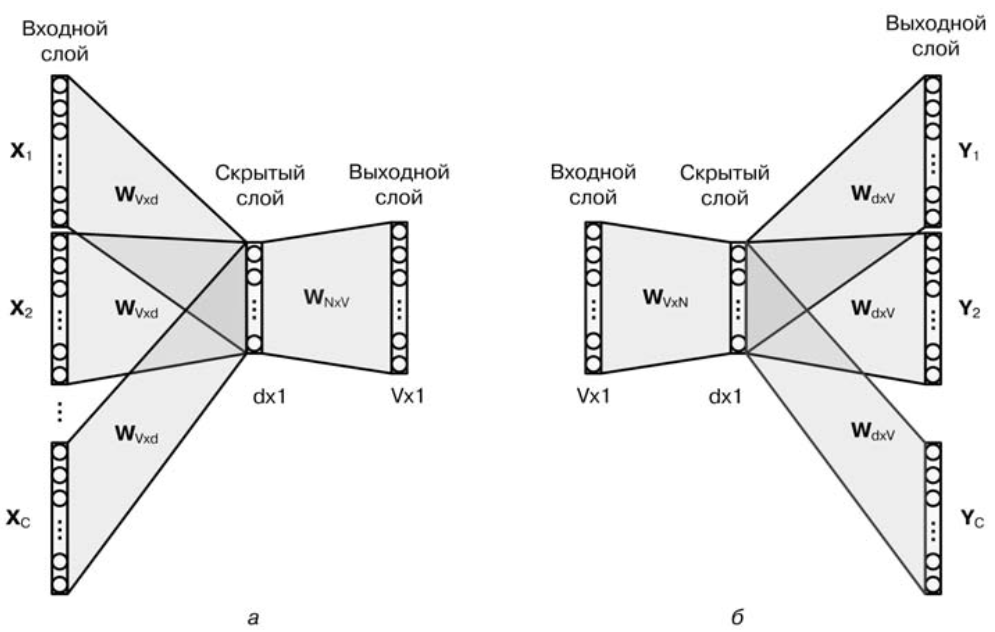

In [32]:
w2v_model = Word2Vec(
    min_count=10,
    window=3,
    size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

Модель имеет множество аргументов:

`min_count` — игнорировать все слова с частотой встречаемости меньше, чем это значение.

`windоw` — размер контекстного окна, о котором говорили тут, обозначает диапазон контекста.

`size` — размер векторного представления слова (word embedding).

`negative` — сколько неконтекстных слов учитывать в обучении, используя negative sampling

`alpha` — начальный learning_rate, используемый в алгоритме обратного распространения ошибки (Backpropogation).

`min_alpha` — минимальное значение learning_rate, на которое может опуститься в процессе обучения.

`sg` — если 1, то используется реализация Skip-gram; если 0, то CBOW.

Далее, требуется получить словарь:

In [33]:
w2v_model.build_vocab(new_data.tokens)

А после уже можно обучить модель, используя метод train:

In [34]:
w2v_model.train(new_data.tokens, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, 
                report_delay=1)

(41929964, 77574090)

Если в дальнейшем не требуется снова обучать модель, то для сохранения оперативной памяти можно написать следующее:

In [35]:
w2v_model.init_sims(replace=True)

Проверка: 

In [36]:
w2v_model.wv.most_similar(positive=["хороший"])

[('плохой', 0.6850206851959229),
 ('фильм', 0.673024594783783),
 ('не', 0.6634974479675293),
 ('хотя', 0.6590251922607422),
 ('это', 0.6272962093353271),
 ('самый', 0.6252634525299072),
 ('понравиться', 0.6202706098556519),
 ('отличный', 0.6042177677154541),
 ('ещё', 0.5956711769104004),
 ('очень', 0.5840091109275818)]

# 3 часть. Подготовка данных для RNN и CNN

### Разделение данных 

Разделим наши тренировочные данные на train(для обучения модели) и test(для получения качества модели).

In [37]:
# разделение выборки на тренировочную и тестовую
data_train, data_test = train_test_split(new_data, 
                                         test_size=0.2, 
                                         random_state=SEED)

print("Data train : %s, Data test:  %s." % (data_train.shape[0], data_test.shape[0]))

Data train : 10982, Data test:  2746.


In [38]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

print("Data train total words : %s , Vocabulary size : %s" % (len(all_training_words), len(TRAINING_VOCAB)))

Data train total words : 2057889 , Vocabulary size : 55263


In [39]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("Data test total words : %s , Vocabulary size : %s" % (len(all_test_words), len(TEST_VOCAB)))

Data test total words : 527914 , Vocabulary size : 31659


In [40]:
data_train['doc_len'] = data_train.content.apply(lambda words: len(words.split(' ')))
data_train['doc_len'].describe()

count    10982.000000
mean       216.621198
std        143.067914
min          7.000000
25%        116.000000
50%        182.000000
75%        280.000000
max       1338.000000
Name: doc_len, dtype: float64

In [41]:
len_mean = data_train['doc_len'].mean()
print(int(len_mean))

216


### Преобразуем слова в векторы.

In [42]:
list_data_train = data_train['content'].tolist()
list_data_test  = data_test['content'].tolist()

In [43]:
# инициализируем параметры словаря и эмбеддингов
MAX_NB_WORDS = len(TRAINING_VOCAB)
MAX_SEQUENCE_LENGTH = int(len_mean)

print("Предложение до предобработки:\n", list_data_train[0])

# с помощью Tokenizer создаем словарь 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='#$%&()*+-/:;<=>@[\\]^{|}~\t\n,.!"«».,-',
                      lower=True,
                      char_level=False)

tokenizer.fit_on_texts(list_data_train)

# заменяем слова на их индексы в нашем словаре
X_train = tokenizer.texts_to_sequences(list_data_train)
X_test = tokenizer.texts_to_sequences(list_data_test)

print("Предложение после замены слов на индексы:\n", X_train[0])

# обрезаем каждое предложение приводим к нужной длинне
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print("Предложение после приведения к единой длинне:\n", X_train[0])

Предложение до предобработки:
 
Признаюсь, я стала его смотреть лишь из-за участия в нем Кристен Стюарт, а она появилась на экране всего два раза на несколько минут…

Этот фильм рассказывает о выборе, который для себя сделал главный герой оставив семью и множество знакомых по всей стране… Лично я считаю такой поступок чистой воды эгоизмом по отношению к родителям, сестре и Рону, который хотел его усыновить. Он покинул семью из-за глупой ссоры с родителями и отправился жить в «дикие условия»! 

Я признаю, что главный герой хотел сбежать от цивилизации, лицемерия, но, по-моему, это самый глупый поступок из всех, о которых я слышала! 

Этот фильм многому учит, но пересматривать его я бы не отважилась, поэтому моя оценка

4 из 10
Предложение после замены слов на индексы:
 [1837, 12405, 4166, 44, 114, 84, 10739, 373, 6954, 4407, 4989, 3205, 192, 31, 5936, 4472, 51984, 10, 1, 1461, 21523, 12, 690, 798, 198, 106, 5496, 2254, 12406, 2862, 4072, 285, 945, 77, 3473, 4536, 2584, 2826, 33687, 1613

In [44]:
print("Индекс слова 'фильм' – {}.".format(tokenizer.word_index['фильм']))
print("Слова 'фильм' встречалось {} раз.".format(tokenizer.word_counts['фильм']))

Индекс слова 'фильм' – 1.
Слова 'фильм' встречалось 21332 раз.


In [45]:
EMBEDDING_DIM = 300 # recommended size in https://arxiv.org/abs/1301.3781

word_index = tokenizer.word_index

vocab = min((len(word_index), MAX_NB_WORDS))

embed_matrix = np.zeros((vocab, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        word_vec = w2v_model[word]
        embed_matrix[i] = word_vec
    except KeyError:
        embed_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


# 4 часть. Обучение. Классификация по трем классам. 


## 4.1 Рекуррентные нейронные сети (Recurrent neural networks, RNN)

Рекуррентные нейронные сети помогают уловить/понять закономерность, которая зависит от времени или порядка. Например, когда мы пытаемся классифицировать какой-то эпизод из фильма, то нам важно знать что было пару эпизодов ранее, или чтобы понять смысл определенного слова, нам нужно знать контекст, который был до него.

Простая рекуррентная нейронная сеть имеет следующее математическое представление:

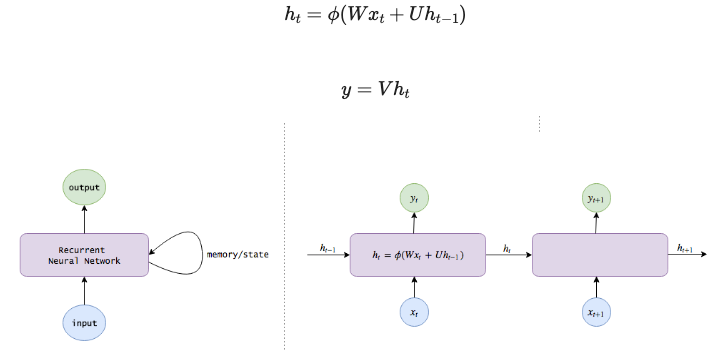

In [46]:
target = []

for i in data_train['label']:
  if i == -1:
    target.append(0)
  elif i == 0:
    target.append(1)
  elif i == 1:
    target.append(2)

data_train['new_label'] = target

train_labels = tf.keras.utils.to_categorical(data_train['new_label'])
train_labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

### Гиперпараметры 

In [47]:
lr = 1e-5
dropout = 0.25     # больше чем 0.3 портят рекурретные модели  
batch_size  = 512  # больше 512 не влезает в карточку, появляется ошибка
num_epochs  = 15   # rnn достаточно и 4 эпох, дальше уже идет переобучение, cnn хватает и 15
num_filters = 128  # больше чем 128 результат хуже
filter_size = 2
num_classes = 3

In [48]:
# инициализируем коллбеки
# остановка обучения если в течение 3 эпох не будет падать val_loss
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

In [49]:
# инициализируем слой эмбеддингов
embedding_layer = Embedding(vocab,
                            EMBEDDING_DIM,
                            weights=[embed_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
                            
model = Sequential()
model.add(embedding_layer)
model.add(SimpleRNN(num_filters))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 216, 300)          16578900  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               54912     
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 16,634,199
Trainable params: 16,634,199
Non-trainable params: 0
_________________________________________________________________


### Обучение SimpleRNN

In [50]:
hist_rnn = model.fit(X_train,
                     train_labels,
                     batch_size = batch_size,
                     epochs = num_epochs,
                     validation_split=0.2,
                     callbacks = callbacks,
                     shuffle=True,
                     verbose=1)

Epoch 1/15
18/18 [==============================] - 9s 295ms/step - loss: 1.1793 - accuracy: 0.4137 - val_loss: 1.0467 - val_accuracy: 0.4998
Epoch 2/15
18/18 [==============================] - 5s 255ms/step - loss: 0.8777 - accuracy: 0.6268 - val_loss: 0.9411 - val_accuracy: 0.5630
Epoch 3/15
18/18 [==============================] - 5s 263ms/step - loss: 0.6708 - accuracy: 0.7315 - val_loss: 0.8916 - val_accuracy: 0.5872
Epoch 4/15
18/18 [==============================] - 4s 237ms/step - loss: 0.5025 - accuracy: 0.8091 - val_loss: 0.9190 - val_accuracy: 0.5922
Epoch 5/15
18/18 [==============================] - 4s 233ms/step - loss: 0.3507 - accuracy: 0.8891 - val_loss: 0.9949 - val_accuracy: 0.5940
Epoch 6/15
18/18 [==============================] - 4s 233ms/step - loss: 0.2014 - accuracy: 0.9449 - val_loss: 1.1188 - val_accuracy: 0.5944


### Проверка 

In [51]:
target_test = []

for i in data_test['label']:
  if i == -1:
    target_test.append(0)
  elif i == 0:
    target_test.append(1)
  elif i == 1:
    target_test.append(2)

data_test['new_label'] = target_test

test_labels = tf.keras.utils.to_categorical(data_test['new_label'])

In [52]:
y_test = data_test['new_label']

y_pred_rnn = model.predict(X_test).round()
pred_df_rnn = pd.DataFrame(data=y_pred_rnn)
y_pred_rnn = pred_df_rnn.values.argmax(1)

In [53]:
print(classification_report(y_test, y_pred_rnn))

              precision    recall  f1-score   support

           0       0.59      0.63      0.61       895
           1       0.49      0.44      0.47       914
           2       0.64      0.67      0.66       937

    accuracy                           0.58      2746
   macro avg       0.58      0.58      0.58      2746
weighted avg       0.58      0.58      0.58      2746



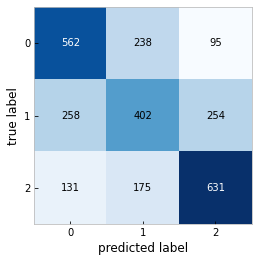

In [54]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_rnn))
plt.show()

In [55]:
predict_rnn = pd.DataFrame(columns=['content'] + ['label'] + ['predict'])
predict_rnn['content'] = data_test['content']
predict_rnn['label'] = y_test
predict_rnn['predict'] = y_pred_rnn
predict_rnn.head()

,content,label,predict
2704,"\n Как человек, достаточно трепетно относ...",2,0
5103,"\nЕще один дуэтный фильм Бартона с Деппом, при...",1,0
1339,"\nУдивляют люди, которые написали отзывы к это...",2,1
13719,\nСюжет:\n\nВ принципе то что происходит в 3-е...,0,2
7028,"\nРассказывая о любом фильме Тима Бартона, при...",1,2


### Графики

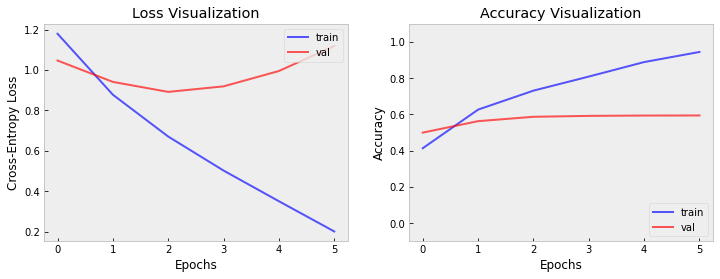

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist_rnn.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist_rnn.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist_rnn.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist_rnn.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()

## 4.2 CNN

Сверточные нейронные сети изначально использовались в обработке изображений и не предназначались для работы с текстом. Это особая разновидность нейронных сетей прямого распространения.

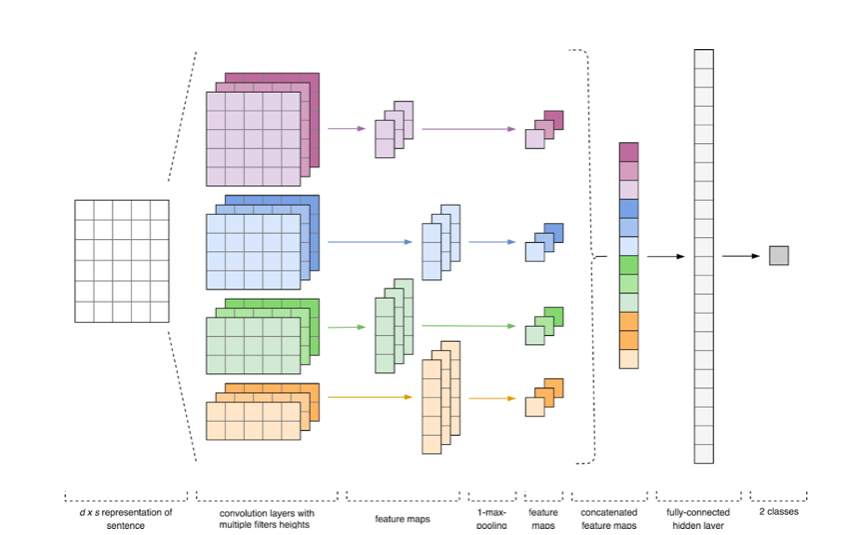

Под прямым распространением подразумевается то, что распространение сигналов по нейронам идет последовательно, от первого слоя до последнего. В сети может быть множество различных скрытых слоев, все зависит от количества данных и сложности задачи. Основными особенностями сети являются чередующиеся слои типа «свертка — субдискретизация», их может быть множество.

Операция свертки происходит путем поэлементного умножения фрагмента входа и ядра свертки, и суммирования полученного результата. Такая сумма будет элементом выхода, который называют картой признаков. Далее взвешенную сумму входов пропускают через функцию активации. 

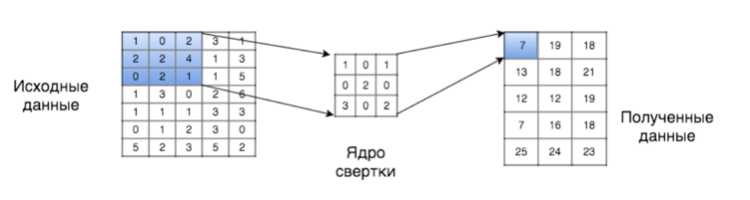

Слой пулинга (подвыборки, субдискретизации) выполняет уменьшение размерности карты признаков. Пулинг разбивает карты признаков на более мелкие ячейки и находит их максимальные значения(max-pooling), т. е. увеличивается «глубина» значений.

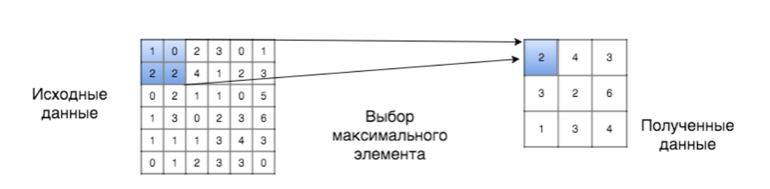

In [57]:
model = Sequential()

model.add(Embedding(vocab, 
                    EMBEDDING_DIM,
                    weights=[embed_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=True))

model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(dropout))


model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(dropout))

model.add(GlobalMaxPooling1D())


model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))


adam = tf.optimizers.Adam(lr)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 216, 300)          16578900  
                                                                 
 conv1d (Conv1D)             (None, 216, 128)          76928     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 108, 128)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 108, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 108, 128)          32896     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 54, 128)          0         
 1D)                                                  

### Обучение CNN

In [58]:
hist_cnn = model.fit(X_train,
                     train_labels,
                     batch_size = batch_size,
                     epochs = num_epochs,
                     validation_split=0.2,
                     callbacks = callbacks,
                     shuffle=True,
                     verbose=2)

Epoch 1/15
18/18 - 12s - loss: 1.2111 - accuracy: 0.3352 - val_loss: 1.1045 - val_accuracy: 0.3792 - 12s/epoch - 651ms/step
Epoch 2/15
18/18 - 1s - loss: 1.1032 - accuracy: 0.3879 - val_loss: 1.1063 - val_accuracy: 0.3637 - 917ms/epoch - 51ms/step
Epoch 3/15
18/18 - 1s - loss: 1.0760 - accuracy: 0.4291 - val_loss: 1.0706 - val_accuracy: 0.4465 - 927ms/epoch - 51ms/step
Epoch 4/15
18/18 - 1s - loss: 1.0092 - accuracy: 0.5238 - val_loss: 1.0221 - val_accuracy: 0.5239 - 930ms/epoch - 52ms/step
Epoch 5/15
18/18 - 1s - loss: 0.9338 - accuracy: 0.5894 - val_loss: 0.9604 - val_accuracy: 0.5849 - 930ms/epoch - 52ms/step
Epoch 6/15
18/18 - 1s - loss: 0.8473 - accuracy: 0.6528 - val_loss: 0.8587 - val_accuracy: 0.6381 - 1s/epoch - 76ms/step
Epoch 7/15
18/18 - 1s - loss: 0.7140 - accuracy: 0.7281 - val_loss: 0.7410 - val_accuracy: 0.6645 - 1s/epoch - 73ms/step
Epoch 8/15
18/18 - 1s - loss: 0.6005 - accuracy: 0.7726 - val_loss: 0.7064 - val_accuracy: 0.6727 - 1s/epoch - 75ms/step
Epoch 9/15
18/18 

In [59]:
y_pred_cnn = model.predict(X_test).round()
pred_df_cnn = pd.DataFrame(data=y_pred_cnn)
y_pred_cnn = pred_df_cnn.values.argmax(1)

### Проверка

In [60]:
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       895
           1       0.56      0.70      0.62       914
           2       0.85      0.68      0.76       937

    accuracy                           0.69      2746
   macro avg       0.71      0.69      0.69      2746
weighted avg       0.71      0.69      0.69      2746



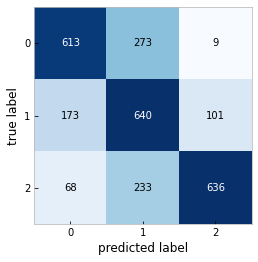

In [61]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_cnn))
plt.show()

In [62]:
predict_cnn = pd.DataFrame(columns=['content'] + ['label'] + ['predict'])
predict_cnn['content'] = data_test['content']
predict_cnn['label'] = y_test
predict_cnn['predict'] = y_pred_cnn
predict_cnn.head()

,content,label,predict
2704,"\n Как человек, достаточно трепетно относ...",2,1
5103,"\nЕще один дуэтный фильм Бартона с Деппом, при...",1,1
1339,"\nУдивляют люди, которые написали отзывы к это...",2,1
13719,\nСюжет:\n\nВ принципе то что происходит в 3-е...,0,0
7028,"\nРассказывая о любом фильме Тима Бартона, при...",1,2


### Графики

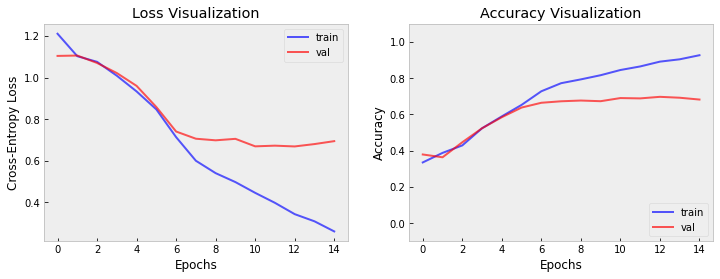

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist_cnn.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist_cnn.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist_cnn.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist_cnn.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()

## 4.3 LSTM

LSTM разработаны специально, чтобы избежать проблемы долговременной зависимости. Запоминание информации на долгие периоды времени – это их обычное поведение, а не что-то, чему они с трудом пытаются обучиться.

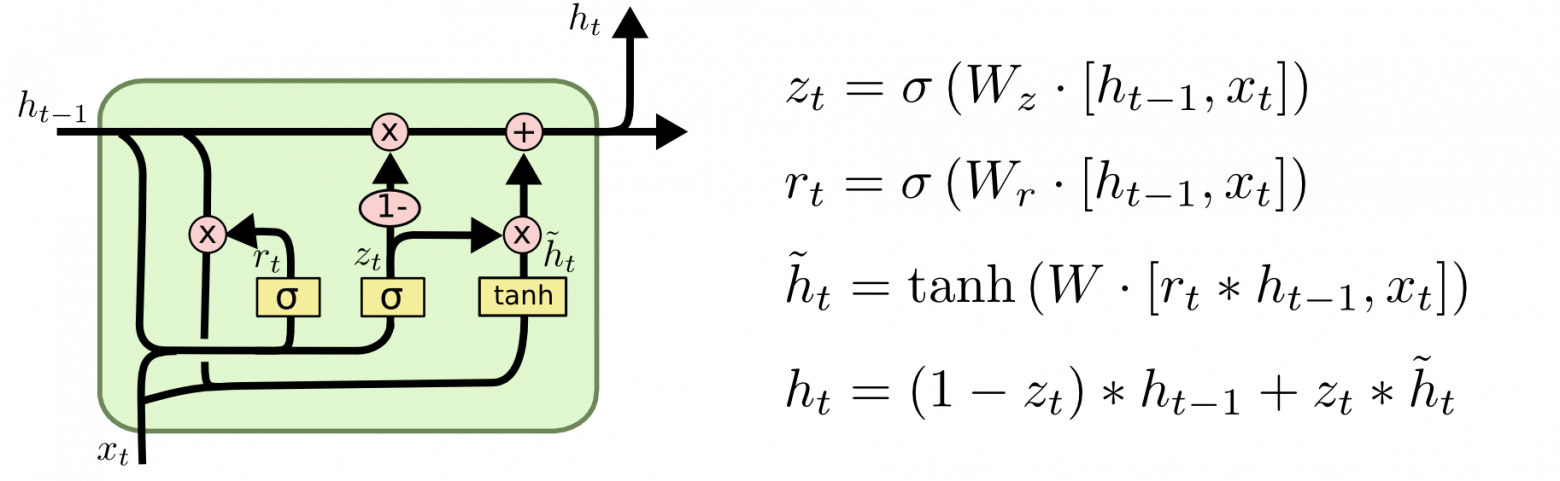

In [64]:



embedding_layer = Embedding(vocab, 
                            EMBEDDING_DIM,
                            weights=[embed_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True,
                            mask_zero=True)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(num_filters))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 216, 300)          16578900  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
Total params: 16,798,935
Trainable params: 16,798,935
Non-trainable params: 0
_________________________________________________________________


### Обучение LSTM

In [65]:
hist_lstm = model.fit(X_train,
                      train_labels,
                      batch_size = batch_size,
                      epochs = num_epochs,
                      validation_split=0.2,
                      callbacks = callbacks,
                      shuffle=True,
                      verbose=2)

Epoch 1/15
18/18 - 15s - loss: 1.0312 - accuracy: 0.4769 - val_loss: 0.9596 - val_accuracy: 0.5553 - 15s/epoch - 847ms/step
Epoch 2/15
18/18 - 10s - loss: 0.8163 - accuracy: 0.6361 - val_loss: 0.8361 - val_accuracy: 0.6036 - 10s/epoch - 540ms/step
Epoch 3/15
18/18 - 10s - loss: 0.6026 - accuracy: 0.7530 - val_loss: 0.7599 - val_accuracy: 0.6559 - 10s/epoch - 547ms/step
Epoch 4/15
18/18 - 10s - loss: 0.4274 - accuracy: 0.8380 - val_loss: 0.8152 - val_accuracy: 0.6741 - 10s/epoch - 550ms/step
Epoch 5/15
18/18 - 10s - loss: 0.2818 - accuracy: 0.9050 - val_loss: 0.9020 - val_accuracy: 0.6623 - 10s/epoch - 557ms/step
Epoch 6/15
18/18 - 10s - loss: 0.1500 - accuracy: 0.9565 - val_loss: 1.1122 - val_accuracy: 0.6504 - 10s/epoch - 553ms/step


In [66]:
y_pred_lstm = model.predict(X_test).round()
pred_df_lstm = pd.DataFrame(data=y_pred_lstm)
y_pred_lstm = pred_df_lstm.values.argmax(1)

### Проверка

In [67]:
print(classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.67      0.72      0.70       895
           1       0.52      0.55      0.53       914
           2       0.74      0.65      0.69       937

    accuracy                           0.64      2746
   macro avg       0.64      0.64      0.64      2746
weighted avg       0.65      0.64      0.64      2746



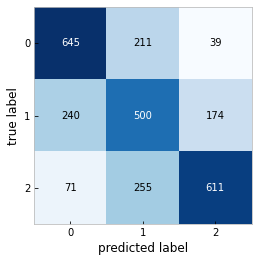

In [68]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_lstm))
plt.show()

In [69]:
predict_lstm = pd.DataFrame(columns=['content'] + ['label'] + ['predict'])
predict_lstm['content'] = data_test['content']
predict_lstm['label'] = y_test
predict_lstm['predict'] = y_pred_lstm
predict_lstm.head()

,content,label,predict
2704,"\n Как человек, достаточно трепетно относ...",2,1
5103,"\nЕще один дуэтный фильм Бартона с Деппом, при...",1,1
1339,"\nУдивляют люди, которые написали отзывы к это...",2,1
13719,\nСюжет:\n\nВ принципе то что происходит в 3-е...,0,2
7028,"\nРассказывая о любом фильме Тима Бартона, при...",1,1


### Графики

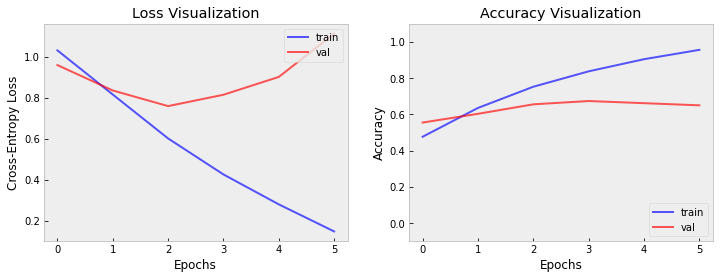

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist_lstm.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist_lstm.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist_lstm.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist_lstm.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()

## 4.4 LSTM with dropout

In [71]:
embedding_layer = Embedding(vocab,
                            EMBEDDING_DIM,
                            weights=[embed_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True,
                            mask_zero=True)

                            
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(dropout))
model.add(LSTM(num_filters, dropout=(dropout/2), recurrent_dropout=(dropout/2)))
model.add(Dropout(dropout))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 216, 300)          16578900  
                                                                 
 dropout_2 (Dropout)         (None, 216, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
 activation_2 (Activation)   (None, 3)                 0         
                                                                 
Total params: 16,798,935
Trainable params: 16,798,935


### Обучение

In [72]:
hist_lstm_do = model.fit(X_train,
                      train_labels,
                      batch_size = batch_size,
                      epochs = num_epochs,
                      validation_split=0.2,
                      callbacks = callbacks,
                      shuffle=True,
                      verbose=2)

Epoch 1/15
18/18 - 23s - loss: 1.0553 - accuracy: 0.4370 - val_loss: 0.9862 - val_accuracy: 0.5353 - 23s/epoch - 1s/step
Epoch 2/15
18/18 - 19s - loss: 0.9161 - accuracy: 0.5727 - val_loss: 0.8800 - val_accuracy: 0.5949 - 19s/epoch - 1s/step
Epoch 3/15
18/18 - 19s - loss: 0.7513 - accuracy: 0.6615 - val_loss: 0.7861 - val_accuracy: 0.6482 - 19s/epoch - 1s/step
Epoch 4/15
18/18 - 19s - loss: 0.6033 - accuracy: 0.7422 - val_loss: 0.7311 - val_accuracy: 0.6932 - 19s/epoch - 1s/step
Epoch 5/15
18/18 - 19s - loss: 0.5045 - accuracy: 0.7942 - val_loss: 0.8582 - val_accuracy: 0.6641 - 19s/epoch - 1s/step
Epoch 6/15
18/18 - 19s - loss: 0.4231 - accuracy: 0.8287 - val_loss: 0.8881 - val_accuracy: 0.6750 - 19s/epoch - 1s/step
Epoch 7/15
18/18 - 19s - loss: 0.3510 - accuracy: 0.8617 - val_loss: 0.9227 - val_accuracy: 0.6882 - 19s/epoch - 1s/step


In [73]:
y_pred_lstm_do = model.predict(X_test).round()
pred_df_lstm_do = pd.DataFrame(data=y_pred_lstm_do)
y_pred_lstm_do = pred_df_lstm_do.values.argmax(1)

### Проверка

In [74]:
print(classification_report(y_test, y_pred_lstm_do))

              precision    recall  f1-score   support

           0       0.68      0.80      0.73       895
           1       0.60      0.45      0.52       914
           2       0.72      0.77      0.74       937

    accuracy                           0.67      2746
   macro avg       0.67      0.67      0.66      2746
weighted avg       0.67      0.67      0.66      2746



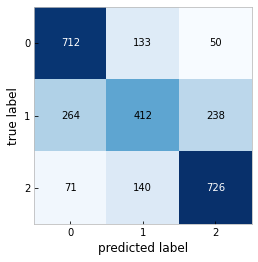

In [75]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_lstm_do))
plt.show()

In [76]:
predict_lstm_do = pd.DataFrame(columns=['content'] + ['label'] + ['predict'])
predict_lstm_do['content'] = data_test['content']
predict_lstm_do['label'] = y_test
predict_lstm_do['predict'] = y_pred_lstm_do
predict_lstm_do.head()

,content,label,predict
2704,"\n Как человек, достаточно трепетно относ...",2,1
5103,"\nЕще один дуэтный фильм Бартона с Деппом, при...",1,0
1339,"\nУдивляют люди, которые написали отзывы к это...",2,1
13719,\nСюжет:\n\nВ принципе то что происходит в 3-е...,0,0
7028,"\nРассказывая о любом фильме Тима Бартона, при...",1,2


### Графики

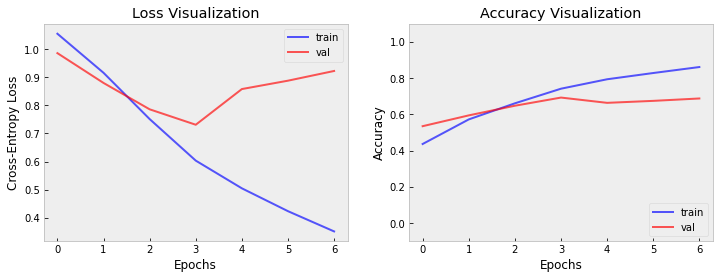

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist_lstm_do.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist_lstm_do.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist_lstm_do.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist_lstm_do.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()

# 5 часть. Бинарная

Проанализировав результаты, был сделан вывод, что точность предсказания снижается из-за нейтральных рецензий. Было решено подробно просмотреть их в датасете. 




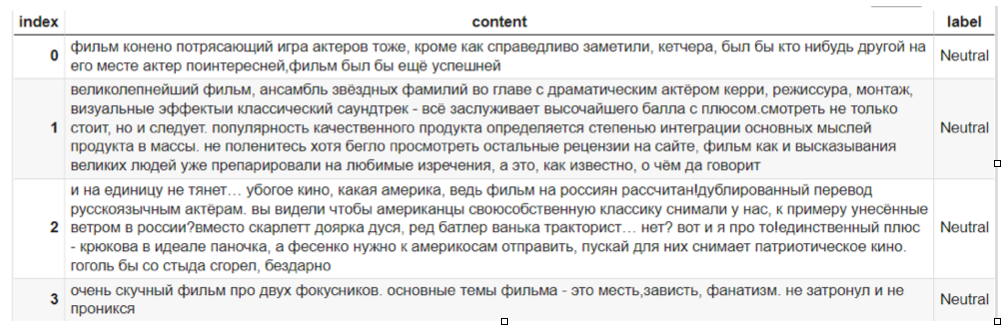

Прочитав содержание нескольких нейтральных рецензий, можно сделать вывод, что они были неправильно размечены в датасете. Такие отзывы можно явно отнести к положительному или отрицательному классу. Для корректного предсказания от отзывов, размеченных как нейтральные, нужно избавиться. 

In [78]:
new_data = pd.concat([df_good, df_bad], axis=0)
new_data = new_data.drop(columns=['level_0', 'index']).reset_index()
new_data = new_data.drop(columns=['index'])
new_data

,content,grade3,label
0,\nИменно из-за этого фильма я полюбил студию D...,Good,1
1,\nОдна из самых лучших существующих мелодрам в...,Good,1
2,\nПосле просмотра фильма Совершенный мир эмоци...,Good,1
3,"\nЗамечательная сказка для взрослых, умная, но...",Good,1
4,\n Вообще фильм изобилует адскими момента...,Good,1
...,...,...,...
9147,\n Неладное заподозрила уже с просмотра т...,Bad,-1
9148,"\nПонятно, что картина итальянского режиссера ...",Bad,-1
9149,"\n Мне лично фильм не понравился, хотя я ...",Bad,-1
9150,"\nЯ начну с того, что буду сразу оправдываться...",Bad,-1


In [79]:
new_data.label.value_counts()

 1    4576
-1    4576
Name: label, dtype: int64

In [80]:
new_data["tokens"] = new_data.content.apply(preprocess)

In [81]:
new_data

,content,grade3,label,tokens
0,\nИменно из-за этого фильма я полюбил студию D...,Good,1,"[именно, это, фильм, полюбить, студия, dreamwo..."
1,\nОдна из самых лучших существующих мелодрам в...,Good,1,"[самый, хороший, существующий, мелодрама, мир,..."
2,\nПосле просмотра фильма Совершенный мир эмоци...,Good,1,"[просмотр, фильм, совершенный, мир, эмоция, пр..."
3,"\nЗамечательная сказка для взрослых, умная, но...",Good,1,"[замечательный, сказка, взрослый, умный, не, з..."
4,\n Вообще фильм изобилует адскими момента...,Good,1,"[вообще, фильм, изобиловать, адский, момент, т..."
...,...,...,...,...
9147,\n Неладное заподозрила уже с просмотра т...,Bad,-1,"[неладный, заподозрить, просмотр, телевизионны..."
9148,"\nПонятно, что картина итальянского режиссера ...",Bad,-1,"[понятно, картина, итальянский, режиссёр, габр..."
9149,"\n Мне лично фильм не понравился, хотя я ...",Bad,-1,"[лично, фильм, не, понравиться, хотя, отлично,..."
9150,"\nЯ начну с того, что буду сразу оправдываться...",Bad,-1,"[начать, сразу, оправдываться, не, малолетка, ..."


## word2vec

In [82]:
w2v_model = Word2Vec(
    min_count=10,
    window=3,
    size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

In [83]:
w2v_model.build_vocab(new_data.tokens)

In [84]:
w2v_model.train(new_data.tokens, 
                total_examples=w2v_model.corpus_count, 
                epochs=40, 
                report_delay=1)

(37325687, 71188600)

In [85]:
w2v_model.init_sims(replace=True)

In [86]:
# разделение выборки на тренировочную и тестовую
data_train, data_test = train_test_split(new_data, 
                                         test_size=0.2, 
                                         random_state=SEED)

print("Data train : %s, Data test:  %s." % (data_train.shape[0], data_test.shape[0]))

Data train : 7321, Data test:  1831.


In [87]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

print("Data train total words : %s , Vocabulary size : %s" % (len(all_training_words), len(TRAINING_VOCAB)))

Data train total words : 1416604 , Vocabulary size : 46912


In [88]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("Data test total words : %s , Vocabulary size : %s" % (len(all_test_words), len(TEST_VOCAB)))

Data test total words : 363111 , Vocabulary size : 26231


In [89]:
data_train['doc_len'] = data_train.content.apply(lambda words: len(words.split(' ')))
data_train['doc_len'].describe()

count    7321.000000
mean      223.900970
std       142.296908
min        12.000000
25%       125.000000
50%       189.000000
75%       285.000000
max      1230.000000
Name: doc_len, dtype: float64

In [90]:
len_mean_2 = data_train['doc_len'].mean()
print(int(len_mean_2))

223


In [91]:
list_data_train = data_train['content'].tolist()
list_data_test  = data_test['content'].tolist()

In [92]:
# инициализируем параметры словаря и эмбеддингов
MAX_NB_WORDS = len(TRAINING_VOCAB)
MAX_SEQUENCE_LENGTH = int(len_mean_2)

print("Предложение до предобработки:\n", list_data_train[0])

# с помощью Tokenizer создаем словарь 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, 
                      filters='#$%&()*+-/:;<=>@[\\]^{|}~\t\n,.!"«».,-',
                      lower=True,
                      char_level=False)

tokenizer.fit_on_texts(list_data_train)

# заменяем слова на их индексы в нашем словаре
X_train = tokenizer.texts_to_sequences(list_data_train)
X_test = tokenizer.texts_to_sequences(list_data_test)

print("Предложение после замены слов на индексы:\n", X_train[0])

# обрезаем каждое предложение приводим к нужной длинне
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print("Предложение после приведения к единой длинне:\n", X_train[0])

Предложение до предобработки:
 
      Посмотрела и я сию фильму, под впечатлением общей оценки Кинопоиска и рецензий. Да, это шедевр, однозначно. 



Актерская игра. Минусовая. Главная героиня не изображала эмоций, якобы многозначительно смотрела туда-сюда. Даже пожар ее не впечатлил (ничто не дрогнуло, ни одно чувство не отразилось в глазах). Один раз она попыталась изобразить страх (уже в замке), как будто спохватилась, что надо вроде бы бояться. Девушка, безусловно, красива, но напрочь лишена актерских дарований. Сергей Крапивенцев (Саша) — более тупого патлатого американизированного типа сложно себе представить. Видимо именно такими режиссер представляет себе прекрасных принцев. Для полного соответствия ему еще и смех надо было добавить в стиле «Гы-гы!» Олег Сукаченко — ему досталось изображать манящий взгляд и манящую полу-улыбку. С этим он справился, но никакого «дьявола» не получилось. Самые живые эмоции были только у эпизодической блондинки.



Персонажи. Извинить актеров с их 

In [93]:
EMBEDDING_DIM = 300 # recommended size in https://arxiv.org/abs/1301.3781

word_index = tokenizer.word_index

vocab = min((len(word_index), MAX_NB_WORDS))

embed_matrix = np.zeros((vocab, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        word_vec = w2v_model[word]
        embed_matrix[i] = word_vec
    except KeyError:
        embed_matrix[i] = np.random.normal(0, np.sqrt(0.25), EMBEDDING_DIM)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [94]:
target = []

for i in data_train['label']:
  if i == -1:
    target.append(0)
  elif i == 1:
    target.append(1)

data_train['new_label'] = target

train_labels = tf.keras.utils.to_categorical(data_train['new_label'])
train_labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [95]:
lr = 1e-5
dropout = 0.25     # больше чем 0.3 портят рекурретные модели  
batch_size  = 512  # больше 512 не влезает в карточку, появляется ошибка
num_epochs  = 15   # rnn достаточно и 4 эпох, дальше уже идет переобучение, cnn хватает и 15
num_filters = 128  # больше чем 128 результат хуже 
filter_size = 2
num_classes = 2

In [96]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint(filepath = 'best_model.h5', monitor= 'val_loss', save_best_only = True)]

## simple RNN

In [97]:
embedding_layer = Embedding(vocab,
                            EMBEDDING_DIM,
                            weights=[embed_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
                            
model = Sequential()
model.add(embedding_layer)
model.add(SimpleRNN(num_filters))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 223, 300)          14073600  
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               54912     
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
 activation_3 (Activation)   (None, 2)                 0         
                                                                 
Total params: 14,128,770
Trainable params: 14,128,770
Non-trainable params: 0
_________________________________________________________________


### Обучение 

In [98]:
hist_rnn = model.fit(X_train,
                     train_labels,
                     batch_size = batch_size,
                     epochs = num_epochs,
                     validation_split=0.2,
                     callbacks = callbacks,
                     shuffle=True,
                     verbose=1)

Epoch 1/15
12/12 [==============================] - 5s 306ms/step - loss: 0.6612 - accuracy: 0.6062 - val_loss: 0.6097 - val_accuracy: 0.7044
Epoch 2/15
12/12 [==============================] - 3s 284ms/step - loss: 0.4754 - accuracy: 0.8105 - val_loss: 0.4836 - val_accuracy: 0.7843
Epoch 3/15
12/12 [==============================] - 3s 292ms/step - loss: 0.3010 - accuracy: 0.8899 - val_loss: 0.4081 - val_accuracy: 0.8191
Epoch 4/15
12/12 [==============================] - 4s 304ms/step - loss: 0.1682 - accuracy: 0.9440 - val_loss: 0.3971 - val_accuracy: 0.8307
Epoch 5/15
12/12 [==============================] - 3s 280ms/step - loss: 0.0796 - accuracy: 0.9795 - val_loss: 0.4143 - val_accuracy: 0.8287
Epoch 6/15
12/12 [==============================] - 3s 276ms/step - loss: 0.0386 - accuracy: 0.9935 - val_loss: 0.4498 - val_accuracy: 0.8334
Epoch 7/15
12/12 [==============================] - 3s 242ms/step - loss: 0.0165 - accuracy: 0.9981 - val_loss: 0.4581 - val_accuracy: 0.8396


In [99]:
target_test = []

for i in data_test['label']:
  if i == -1:
    target_test.append(0)
  elif i == 1:
    target_test.append(1)

data_test['new_label'] = target_test

test_labels = tf.keras.utils.to_categorical(data_test['new_label'])

In [100]:
y_test = data_test['new_label']

y_pred_rnn = model.predict(X_test).round()
pred_df_rnn = pd.DataFrame(data=y_pred_rnn)
y_pred_rnn = pred_df_rnn.values.argmax(1)

Проверка

In [101]:
print(classification_report(y_test, y_pred_rnn))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       926
           1       0.86      0.80      0.83       905

    accuracy                           0.84      1831
   macro avg       0.84      0.84      0.84      1831
weighted avg       0.84      0.84      0.84      1831



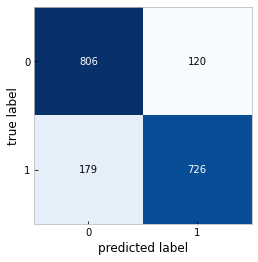

In [102]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_rnn))
plt.show()

In [103]:
predict_rnn = pd.DataFrame(columns=['content'] + ['label'] + ['predict'])
predict_rnn['content'] = data_test['content']
predict_rnn['label'] = y_test
predict_rnn['predict'] = y_pred_rnn
predict_rnn.head()

,content,label,predict
5075,"\n Бессмысленное кино, снятое по избитым ...",0,0
6872,"\nПоследовав за приятелем, начал оскароносный ...",0,0
1159,\nВначале это было как необычная экзотическая ...,1,0
1486,"\nК стыду своему признаюсь, что до сегодняшнег...",1,1
763,\nКлинт Иствуд хороший режиссер и ещё лучший а...,1,1


### Графики

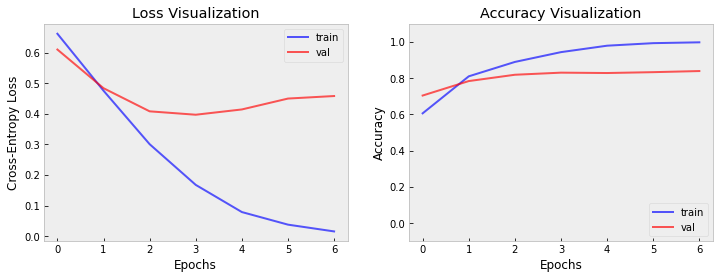

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist_rnn.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist_rnn.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist_rnn.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist_rnn.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()

## CNN

In [105]:
model = Sequential()

model.add(Embedding(vocab, 
                    EMBEDDING_DIM,
                    weights=[embed_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=True))

model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(dropout))


model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(dropout))

model.add(GlobalMaxPooling1D())


model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))


adam = tf.optimizers.Adam(lr)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 223, 300)          14073600  
                                                                 
 conv1d_2 (Conv1D)           (None, 223, 128)          76928     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 111, 128)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 111, 128)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 111, 128)          32896     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 55, 128)          0         
 1D)                                                  

### Обучение

In [106]:
hist_cnn = model.fit(X_train,
                     train_labels,
                     batch_size = batch_size,
                     epochs = num_epochs,
                     validation_split=0.2,
                     callbacks = callbacks,
                     shuffle=True,
                     verbose=2)

Epoch 1/15
12/12 - 2s - loss: 0.7624 - accuracy: 0.5046 - val_loss: 0.6988 - val_accuracy: 0.5604 - 2s/epoch - 158ms/step
Epoch 2/15
12/12 - 1s - loss: 0.6865 - accuracy: 0.6018 - val_loss: 0.6797 - val_accuracy: 0.6102 - 653ms/epoch - 54ms/step
Epoch 3/15
12/12 - 1s - loss: 0.6516 - accuracy: 0.6848 - val_loss: 0.6524 - val_accuracy: 0.6928 - 656ms/epoch - 55ms/step
Epoch 4/15
12/12 - 1s - loss: 0.6036 - accuracy: 0.7450 - val_loss: 0.6106 - val_accuracy: 0.7256 - 680ms/epoch - 57ms/step
Epoch 5/15
12/12 - 1s - loss: 0.5505 - accuracy: 0.7736 - val_loss: 0.5729 - val_accuracy: 0.7270 - 654ms/epoch - 55ms/step
Epoch 6/15
12/12 - 1s - loss: 0.4862 - accuracy: 0.8140 - val_loss: 0.5340 - val_accuracy: 0.7666 - 665ms/epoch - 55ms/step
Epoch 7/15
12/12 - 1s - loss: 0.4033 - accuracy: 0.8576 - val_loss: 0.4811 - val_accuracy: 0.7843 - 665ms/epoch - 55ms/step
Epoch 8/15
12/12 - 1s - loss: 0.3133 - accuracy: 0.8960 - val_loss: 0.4104 - val_accuracy: 0.8280 - 655ms/epoch - 55ms/step
Epoch 9/15

In [107]:
y_pred_cnn = model.predict(X_test).round()
pred_df_cnn = pd.DataFrame(data=y_pred_cnn)
y_pred_cnn = pred_df_cnn.values.argmax(1)

### Проверка

In [108]:
print(classification_report(y_test, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       926
           1       0.91      0.91      0.91       905

    accuracy                           0.91      1831
   macro avg       0.91      0.91      0.91      1831
weighted avg       0.91      0.91      0.91      1831



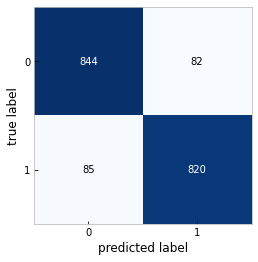

In [109]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_cnn))
plt.show()

In [110]:
predict_cnn = pd.DataFrame(columns=['content'] + ['label'] + ['predict'])
predict_cnn['content'] = data_test['content']
predict_cnn['label'] = y_test
predict_cnn['predict'] = y_pred_cnn
predict_cnn.head()

,content,label,predict
5075,"\n Бессмысленное кино, снятое по избитым ...",0,0
6872,"\nПоследовав за приятелем, начал оскароносный ...",0,0
1159,\nВначале это было как необычная экзотическая ...,1,1
1486,"\nК стыду своему признаюсь, что до сегодняшнег...",1,1
763,\nКлинт Иствуд хороший режиссер и ещё лучший а...,1,1


### Графики

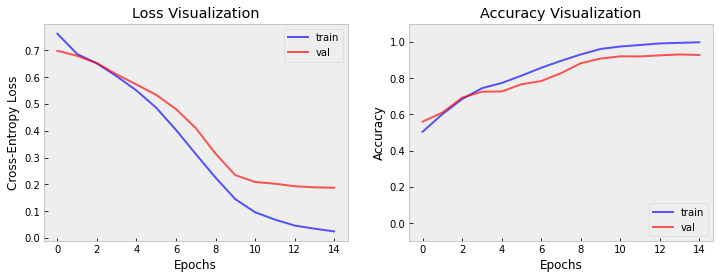

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist_cnn.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist_cnn.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist_cnn.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist_cnn.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()

## LSTM

In [112]:
embedding_layer = Embedding(vocab,
                            EMBEDDING_DIM,
                            weights=[embed_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True,
                            mask_zero=True)

model = Sequential()
model.add(embedding_layer)
model.add(LSTM(num_filters))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

adam = tf.optimizers.Adam(lr)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 223, 300)          14073600  
                                                                 
 lstm_2 (LSTM)               (None, 128)               219648    
                                                                 
 dense_8 (Dense)             (None, 2)                 258       
                                                                 
 activation_4 (Activation)   (None, 2)                 0         
                                                                 
Total params: 14,293,506
Trainable params: 14,293,506
Non-trainable params: 0
_________________________________________________________________


### Обучение

In [113]:
hist_lstm = model.fit(X_train,
                      train_labels,
                      batch_size = batch_size,
                      epochs = num_epochs,
                      validation_split=0.2,
                      callbacks = callbacks,
                      shuffle=True,
                      verbose=2)

Epoch 1/15
12/12 - 12s - loss: 0.6620 - accuracy: 0.6125 - val_loss: 0.6003 - val_accuracy: 0.7208 - 12s/epoch - 1s/step
Epoch 2/15
12/12 - 7s - loss: 0.4986 - accuracy: 0.7782 - val_loss: 0.4151 - val_accuracy: 0.8137 - 7s/epoch - 573ms/step
Epoch 3/15
12/12 - 7s - loss: 0.2912 - accuracy: 0.8825 - val_loss: 0.3142 - val_accuracy: 0.8730 - 7s/epoch - 574ms/step
Epoch 4/15
12/12 - 7s - loss: 0.1578 - accuracy: 0.9505 - val_loss: 0.2655 - val_accuracy: 0.9010 - 7s/epoch - 563ms/step
Epoch 5/15
12/12 - 7s - loss: 0.0806 - accuracy: 0.9742 - val_loss: 0.2842 - val_accuracy: 0.9010 - 7s/epoch - 573ms/step
Epoch 6/15
12/12 - 7s - loss: 0.0445 - accuracy: 0.9892 - val_loss: 0.3059 - val_accuracy: 0.9092 - 7s/epoch - 559ms/step
Epoch 7/15
12/12 - 7s - loss: 0.0225 - accuracy: 0.9959 - val_loss: 0.3108 - val_accuracy: 0.9099 - 7s/epoch - 551ms/step


In [114]:
y_pred_lstm = model.predict(X_test).round()
pred_df_lstm = pd.DataFrame(data=y_pred_lstm)
y_pred_lstm = pred_df_lstm.values.argmax(1)

### Проверка

In [115]:
print(classification_report(y_test, y_pred_lstm))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87       926
           1       0.86      0.89      0.87       905

    accuracy                           0.87      1831
   macro avg       0.87      0.87      0.87      1831
weighted avg       0.87      0.87      0.87      1831



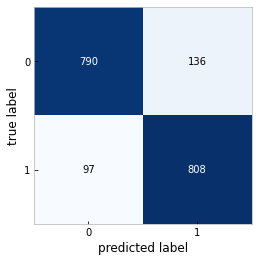

In [116]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred_lstm))
plt.show()

In [117]:
predict_lstm = pd.DataFrame(columns=['content'] + ['label'] + ['predict'])
predict_lstm['content'] = data_test['content']
predict_lstm['label'] = y_test
predict_lstm['predict'] = y_pred_lstm
predict_lstm.head()

,content,label,predict
5075,"\n Бессмысленное кино, снятое по избитым ...",0,0
6872,"\nПоследовав за приятелем, начал оскароносный ...",0,1
1159,\nВначале это было как необычная экзотическая ...,1,1
1486,"\nК стыду своему признаюсь, что до сегодняшнег...",1,1
763,\nКлинт Иствуд хороший режиссер и ещё лучший а...,1,1


### Графики

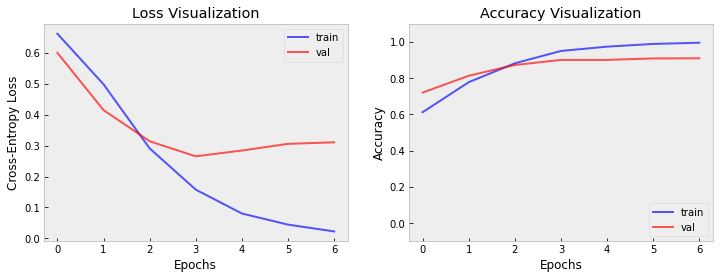

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hist_lstm.history['loss'], lw=2.0, color='b', alpha=0.65, label='train')
ax1.plot(hist_lstm.history['val_loss'], lw=2.0, color='r', alpha=0.65, label='val')
ax1.set_title('Loss Visualization')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Cross-Entropy Loss')
ax1.legend(loc='upper right')
ax2.plot(hist_lstm.history['accuracy'], lw=2.0, color='b', alpha=0.65, label='train')
ax2.plot(hist_lstm.history['val_accuracy'], lw=2.0, color='r', alpha=0.65, label='val')
ax2.set_title('Accuracy Visualization')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')

ax1.grid(False)
ax2.grid(False)

ax2.set_ylim(-0.1, 1.1)
plt.show()

## вывод

1. Построив и обучив модель Word2Vec на своих данных, убедились в том, что помимо эффективного построения векторных представлений слов, модель также сохраняет их семантику;

2. Сверточная нейронная сеть показала себя лучше, чем рекуррентная несмотря на то, что ее часто применяют в обработке изображений, а не текста. Это может быть связано с тем, что архитектуры нейросетей были очень простыми и рекуррентной сети не хватило модификации для лучшего результата;

3. Неудовлетворительный результат первого эксперимента был связан с тем, что текст некоторых рецензий не соответствовал нейтральной оценке, поставленной автором. Нейронные сети распознали их тональность и распределили по истинным классам, поэтому предсказанные значения не совпали с ожидаемыми и точность снизилась. Таким образом, это отличный способ узнать истинное настроение авторов по тексту их рецензии, не учитывая общую оценку, основанную на разметке.